# A quick look at deprivation and covid deaths

### functions for repetative tasks

In [135]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

# construct tables from index of multiple deprication and covid data
def build_dataset(statistical_geography):
    # choose the area to investigate
    area = statistical_geography+"_name"
    
    # retrieve IMD data from local database along with geography parameters
    with sqlite3.connect('/Users/Thomas Walsh/data.db') as conn:
        IMD = pd.read_sql("""SELECT DISTINCT(IMD.lsoa_code),
                                     IMD_score,
                                     income_score,
                                     employment_score,
                                     poplation AS population,
                                     geo.msoa_code,
                                     geo.msoa_name,
                                     geo.lad_code,
                                     geo.lad_name
                                FROM IMD 
                           LEFT JOIN geographies AS geo
                                     ON geo.lsoa_code=IMD.lsoa_code
                                     ;""", conn)
    
    # IMD research report dictates population average to aggregate to higher geographies
    weighted_average = lambda x: np.average(x, weights=IMD.loc[x.index,'population'])
    agg_func = weighted_average                            # helper to make faster changes
    IMD_msoa = IMD.groupby(area).agg({'IMD_score': agg_func,
                                     'income_score': agg_func,
                                     'employment_score': agg_func,
                                     'population': 'sum'})

    # ranks and deciles are constructed from aggregate scores
    for metric in ['IMD', 'income', 'employment']:
        IMD_msoa[metric+"_rank"] = IMD_msoa[metric+"_score"].rank(ascending=False)
        IMD_msoa[metric+"_decile"] = pd.qcut(IMD_msoa[metric+"_score"],10, labels=np.arange(10,0,-1)).astype(int)

    # read in the data from "Table 5" in the covid spreadsheet
    covid_deaths = pd.read_excel(io='referencetablesworkbook2.xlsx', # in/out file
                                 sheet_name='Table 5',                      # data sheet
                                 header=12,                                 # skip 12 lines
                                 names=['msoa_code',                        # define column names
                                        'msoa_name',
                                        'common_name',
                                        'march_covid',
                                        'april_covid',
                                        'may_covid',
                                        'june_covid',
                                        'sum_covid',
                                        'march_other',
                                        'april_other',
                                        'may_other',
                                        'june_other',
                                        'sum_other',
                                        'march_all',
                                        'april_all',
                                        'may_all',
                                        'june_all',
                                        'sum_all',
                                       ],
                                 usecols="A:C,E:I,K:O,Q:U"                # use these columns from the spreadsheet
                                 )

    if area != 'msoa_name':
    # then we need to aggreagate the covid data. Get lookup table and sum to higher geography
        with sqlite3.connect('/Users/Thomas Walsh/data.db') as conn:
            lookup = pd.read_sql("SELECT DISTINCT msoa_code, {} FROM geographies;".format(area), conn)

        covid_deaths = covid_deaths.join(lookup.set_index('msoa_code'), on='msoa_code', how='left')
        covid_deaths = covid_deaths.groupby(area).sum()

    # just keep total values for now--get rid of the rest.
    covid_deaths.drop([x for x in covid_deaths.columns[3:] if ("sum" not in x)], axis=1, inplace=True)
    
    
    # join covid data to IMD--slight syntax change depending on geographies
    if area != "msoa_name":
        IMD_covid = IMD_msoa.join(covid_deaths, how='left')
    
    else:
        IMD_covid = IMD_msoa.join(covid_deaths.set_index('msoa_name'), how='left')
    
    # add covid deaths/100,000 column
    IMD_covid['covid/100k'] = IMD_covid['sum_covid']/IMD_covid['population']*100000
    
    # give us the result!
    return IMD_covid

# for making scatter plots with lines of best fits
def scatter_plot(df, x, y, trendline=True, title=None):
    
    from scipy import stats
    
    # create the canvas and plot data points
    fig, ax = plt.subplots(1, figsize=(12,12))
    df.plot.scatter(x, y, ax=ax)#figsize=(12,12))
    
    #title
    ax.set_title(title, fontsize=20)
    
    # x-axis paramters
    ax.set_xlabel(x.replace("_", " ").upper(), fontsize=20)
    ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=20)
    ax.xaxis.set_ticks_position('none')
    
    # y-axis parameters
    ax.set_ylabel(y.replace("_", " ").upper(), fontsize=20, rotation=0, labelpad=40)
    ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=20)
    ax.yaxis.set_ticks_position('none')
    
    # add the trendline (if desired)
    if trendline:
        # get line
        slope, intercept, r_value, p_value, std_err = stats.linregress(df[x], df[y])
        
        #plot line
        x_trend = np.arange(df[x].min(), df[x].max(),0.1)
        y_trend = slope*x_trend + intercept
        plt.plot(x_trend, y_trend, c='r')

    # show me the graph!
    plt.show()
    
    # print paramters of trendline if present
    if trendline:
        print("trendline parameters:")
        print("     gradiant:", slope)
        print("    intercept:", intercept)
        print("      r-value:", r_value)

# for drawing heat maps
def draw_heatmap(df, absolute=False):
    import seaborn as sns
    
    # show actual r-values (for direction of correlation) or positive values (for comparing magnitude)
    if absolute:
        # magnitude
        sns.heatmap(df.corr().abs())
        
    else:
        #direction
        sns.heatmap(df.corr())

    # show it to me!
    plt.show()


## Create datasets for desired geographic areas

In [115]:
# at the msoa-level (level we have covid data for)
msoa = build_dataset('msoa')

In [116]:
# at the local authority level (requires aggregation of covid data)
lad = build_dataset('lad')

# Plots!

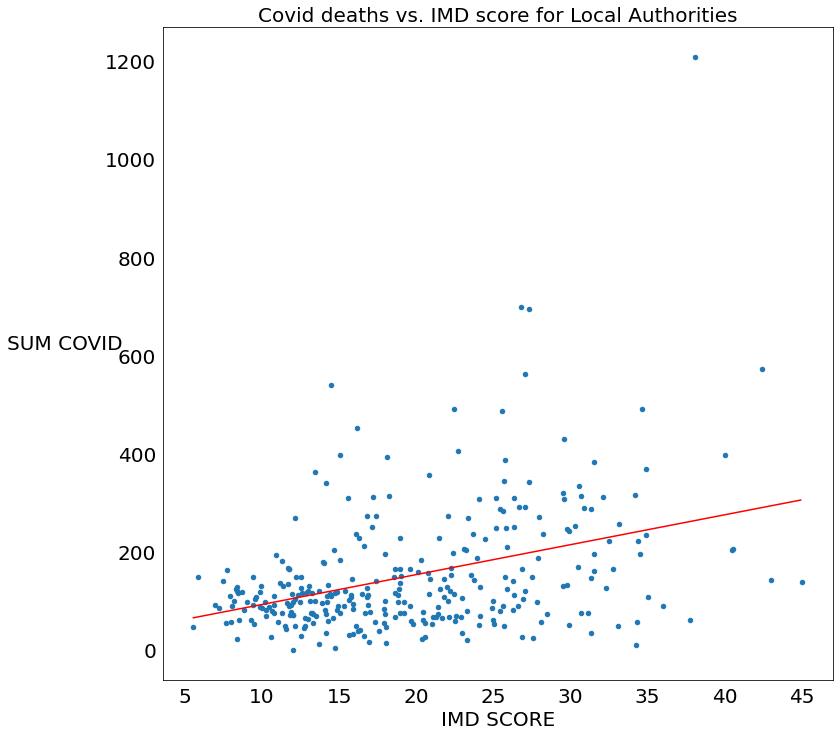

trendline parameters:
     gradiant: 6.086308193213444
    intercept: 32.18944941241591
      r-value: 0.380371023830703
That datapoint with the allegedly huge number of deaths is Birmingham


In [128]:
scatter_plot(lad, 'IMD_score', 'sum_covid', title="Covid deaths vs. IMD score for Local Authorities")
print("That datapoint with the allegedly huge number of deaths is",
      lad[lad.sum_covid==lad.sum_covid.max()].index.values[0])

correlation of 0.38 is reasonable. That datapoint at the top is probably an error in the source data (missed decimal place, maybe?)

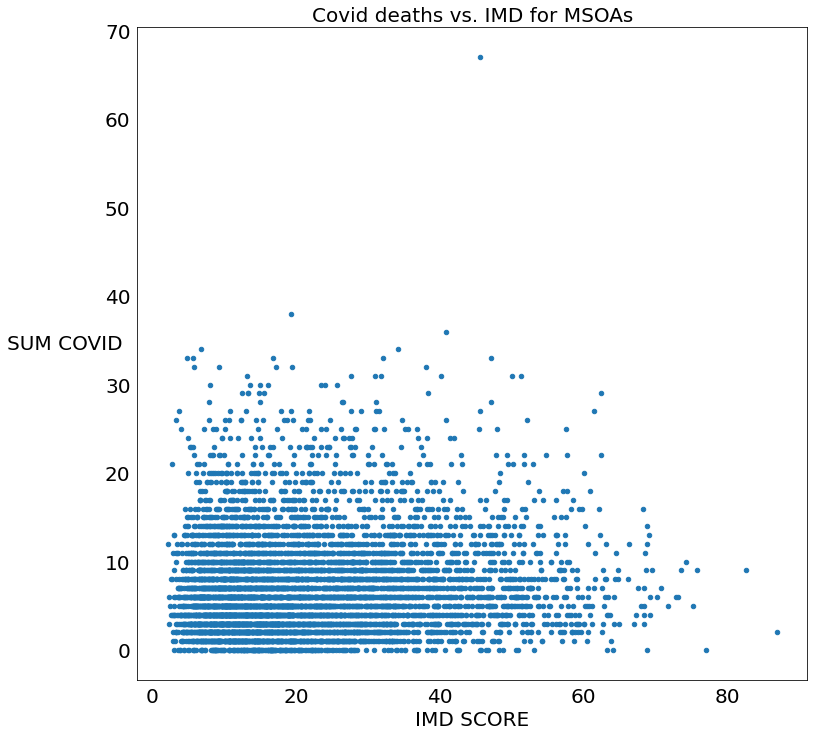

In [129]:
scatter_plot(msoa, 'IMD_score', 'sum_covid', trendline=False, title="Covid deaths vs. IMD for MSOAs")

Weirldy, there look to be almost no correlation between deprivation in MSOAs and covid deaths. This is a bit suprising to me--why is this?

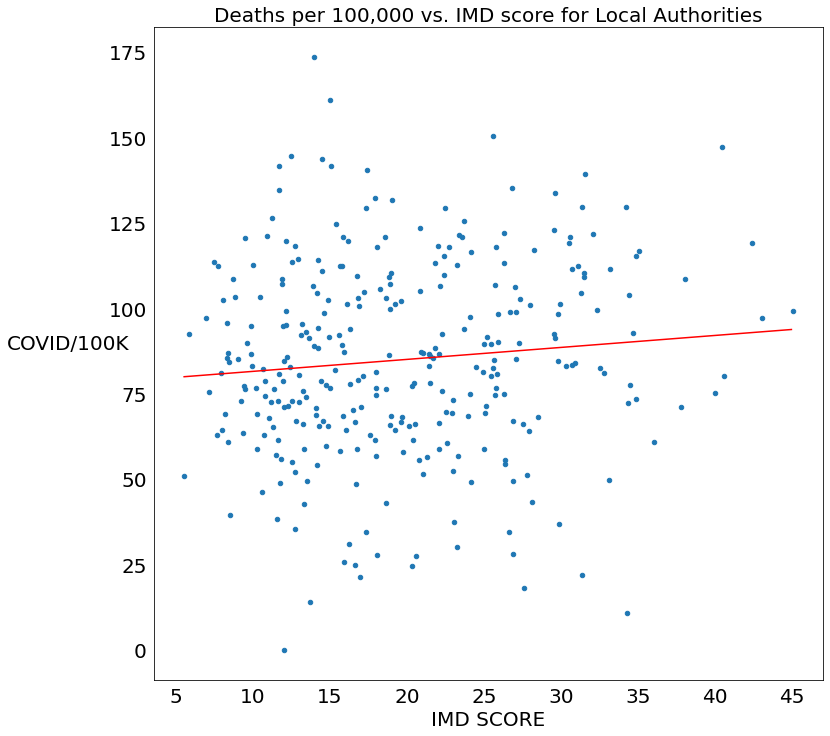

trendline parameters:
     gradiant: 0.3506357612360133
    intercept: 78.06403409199292
      r-value: 0.09897779072311151


In [130]:
scatter_plot(lad, 'IMD_score', 'covid/100k', title="Deaths per 100,000 vs. IMD score for Local Authorities")

Accounting for population, the relationship between deprivation and covid deaths starts to dissapear.

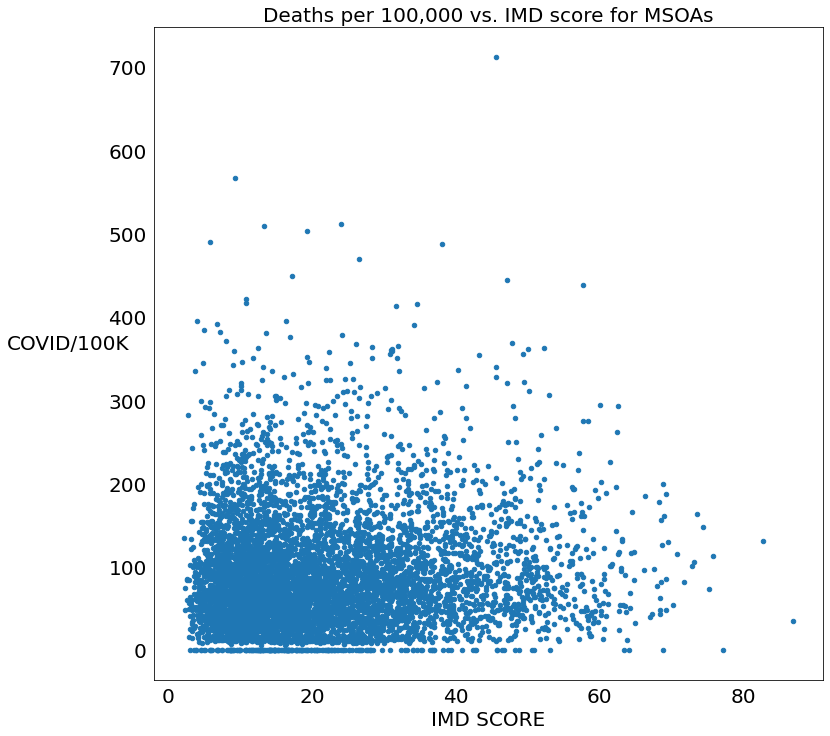

In [131]:
scatter_plot(msoa, 'IMD_score', 'covid/100k', trendline=False, title="Deaths per 100,000 vs. IMD score for MSOAs")

Again, it's not really there for MSOAs

## Heatmaps and correlation matrices
Show how strongly correlated the different parameters are (assuming the relationship is linear--it might not be!)
An r-value of 0 means two parameters have nothing to do with one another. A value of 1 means they are perfectly correlated, and one perfectly explains the behaviour of another. A value of -1 means the same, except an *increase* in one parameter perfectly explains a *decrease* in the other. Beware the different colour-keys in these (they're just on automatic for now).

Note that covid must be correlted with total deaths, IMD with income and emplyment deprevation (since it's derrived from them) etc. It's the relationship between covid paramters and other things that are of interest here.

### Local Authorities

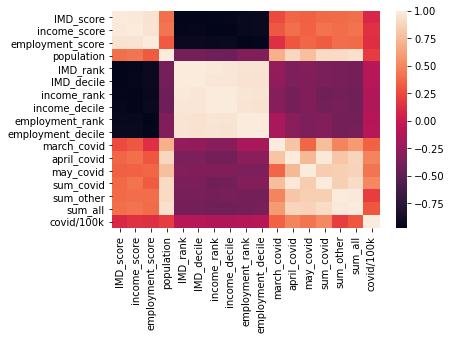

,IMD_score,income_score,employment_score,population,IMD_rank,IMD_decile,income_rank,income_decile,employment_rank,employment_decile,march_covid,april_covid,may_covid,sum_covid,sum_other,sum_all,covid/100k
IMD_score,1.000000,0.979496,0.952889,0.398897,-0.976152,-0.967377,-0.958285,-0.949505,-0.936660,-0.929255,0.251384,0.366310,0.343667,0.380371,0.389251,0.399455,0.098978
income_score,0.979496,1.000000,0.954189,0.423389,-0.955619,-0.948858,-0.974276,-0.965877,-0.934965,-0.925049,0.310723,0.404706,0.348444,0.415015,0.395702,0.414487,0.143578
employment_score,0.952889,0.954189,1.000000,0.319613,-0.928926,-0.920747,-0.931575,-0.923344,-0.969198,-0.960560,0.136181,0.300063,0.359409,0.325702,0.390833,0.384394,0.131010
population,0.398897,0.423389,0.319613,1.000000,-0.387497,-0.388115,-0.416310,-0.413356,-0.334993,-0.333987,0.705584,0.894402,0.773676,0.911704,0.909717,0.940316,0.192201
IMD_rank,-0.976152,-0.955619,-0.928926,-0.387497,1.000000,0.994988,0.979702,0.973925,0.958557,0.954366,-0.249582,-0.347461,-0.327013,-0.363082,-0.374684,-0.383600,-0.083023
IMD_decile,-0.967377,-0.948858,-0.920747,-0.388115,0.994988,1.000000,0.975590,0.970362,0.952812,0.948422,-0.254079,-0.347716,-0.327821,-0.364064,-0.372960,-0.382623,-0.082639
income_rank,-0.958285,-0.974276,-0.931575,-0.416310,0.979702,0.975590,1.000000,0.994988,0.962109,0.955994,-0.305733,-0.386060,-0.333288,-0.398211,-0.384740,-0.401430,-0.118542
income_decile,-0.949505,-0.965877,-0.923344,-0.413356,0.973925,0.970362,0.994988,1.000000,0.956709,0.950731,-0.299491,-0.382782,-0.329963,-0.393628,-0.381018,-0.397330,-0.114871
employment_rank,-0.936660,-0.934965,-0.969198,-0.334993,0.958557,0.952812,0.962109,0.956709,1.000000,0.994988,-0.154674,-0.294568,-0.348429,-0.322142,-0.389127,-0.382081,-0.095438
employment_decile,-0.929255,-0.925049,-0.960560,-0.333987,0.954366,0.948422,0.955994,0.950731,0.994988,1.000000,-0.150455,-0.289576,-0.346849,-0.317532,-0.388299,-0.380103,-0.083059


In [140]:
draw_heatmap(lad)
lad.corr()

### Local Authorities (absolute values)

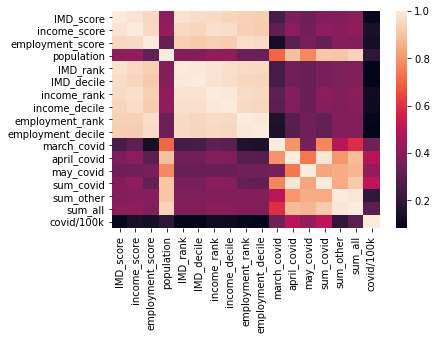

,IMD_score,income_score,employment_score,population,IMD_rank,IMD_decile,income_rank,income_decile,employment_rank,employment_decile,march_covid,april_covid,may_covid,sum_covid,sum_other,sum_all,covid/100k
IMD_score,1.000000,0.979496,0.952889,0.398897,0.976152,0.967377,0.958285,0.949505,0.936660,0.929255,0.251384,0.366310,0.343667,0.380371,0.389251,0.399455,0.098978
income_score,0.979496,1.000000,0.954189,0.423389,0.955619,0.948858,0.974276,0.965877,0.934965,0.925049,0.310723,0.404706,0.348444,0.415015,0.395702,0.414487,0.143578
employment_score,0.952889,0.954189,1.000000,0.319613,0.928926,0.920747,0.931575,0.923344,0.969198,0.960560,0.136181,0.300063,0.359409,0.325702,0.390833,0.384394,0.131010
population,0.398897,0.423389,0.319613,1.000000,0.387497,0.388115,0.416310,0.413356,0.334993,0.333987,0.705584,0.894402,0.773676,0.911704,0.909717,0.940316,0.192201
IMD_rank,0.976152,0.955619,0.928926,0.387497,1.000000,0.994988,0.979702,0.973925,0.958557,0.954366,0.249582,0.347461,0.327013,0.363082,0.374684,0.383600,0.083023
IMD_decile,0.967377,0.948858,0.920747,0.388115,0.994988,1.000000,0.975590,0.970362,0.952812,0.948422,0.254079,0.347716,0.327821,0.364064,0.372960,0.382623,0.082639
income_rank,0.958285,0.974276,0.931575,0.416310,0.979702,0.975590,1.000000,0.994988,0.962109,0.955994,0.305733,0.386060,0.333288,0.398211,0.384740,0.401430,0.118542
income_decile,0.949505,0.965877,0.923344,0.413356,0.973925,0.970362,0.994988,1.000000,0.956709,0.950731,0.299491,0.382782,0.329963,0.393628,0.381018,0.397330,0.114871
employment_rank,0.936660,0.934965,0.969198,0.334993,0.958557,0.952812,0.962109,0.956709,1.000000,0.994988,0.154674,0.294568,0.348429,0.322142,0.389127,0.382081,0.095438
employment_decile,0.929255,0.925049,0.960560,0.333987,0.954366,0.948422,0.955994,0.950731,0.994988,1.000000,0.150455,0.289576,0.346849,0.317532,0.388299,0.380103,0.083059


In [137]:
draw_heatmap(lad, absolute=True)
lad.corr().abs()

### MSOAs

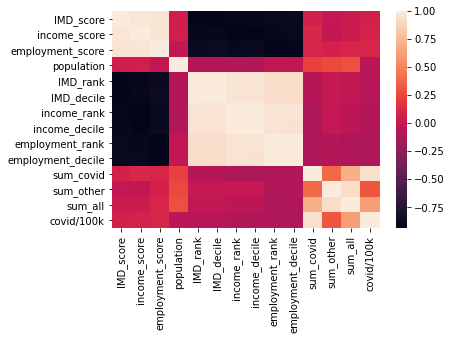

,IMD_score,income_score,employment_score,population,IMD_rank,IMD_decile,income_rank,income_decile,employment_rank,employment_decile,sum_covid,sum_other,sum_all,covid/100k
IMD_score,1.000000,0.976255,0.957567,0.046893,-0.938284,-0.929397,-0.912839,-0.904142,-0.892932,-0.884983,0.083185,-0.006963,0.027400,0.072531
income_score,0.976255,1.000000,0.963033,0.062109,-0.909281,-0.900853,-0.933665,-0.924950,-0.902071,-0.894200,0.106867,-0.007731,0.036145,0.090175
employment_score,0.957567,0.963033,1.000000,-0.016103,-0.884079,-0.875675,-0.897085,-0.887945,-0.927507,-0.918139,0.100094,0.082452,0.103580,0.106293
population,0.046893,0.062109,-0.016103,1.000000,-0.070057,-0.070746,-0.087268,-0.089241,-0.008925,-0.012018,0.229441,0.263406,0.295275,-0.042749
IMD_rank,-0.938284,-0.909281,-0.884079,-0.070057,1.000000,0.994987,0.964762,0.959585,0.939305,0.935025,-0.078853,0.014057,-0.020177,-0.061505
IMD_decile,-0.929397,-0.900853,-0.875675,-0.070746,0.994987,1.000000,0.959864,0.955369,0.934652,0.930850,-0.079196,0.013475,-0.020764,-0.061683
income_rank,-0.912839,-0.933665,-0.897085,-0.087268,0.964762,0.959864,1.000000,0.994987,0.962138,0.957527,-0.108522,-0.000065,-0.042858,-0.085239
income_decile,-0.904142,-0.924950,-0.887945,-0.089241,0.959585,0.955369,0.994987,1.000000,0.956721,0.952853,-0.106913,0.000332,-0.041915,-0.083164
employment_rank,-0.892932,-0.902071,-0.927507,-0.008925,0.939305,0.934652,0.962138,0.956721,1.000000,0.994987,-0.101521,-0.084715,-0.105903,-0.099418
employment_decile,-0.884983,-0.894200,-0.918139,-0.012018,0.935025,0.930850,0.957527,0.952853,0.994987,1.000000,-0.100527,-0.082176,-0.103536,-0.097671


In [138]:
draw_heatmap(msoa)
msoa.corr()

### MSOAs (absolute values)

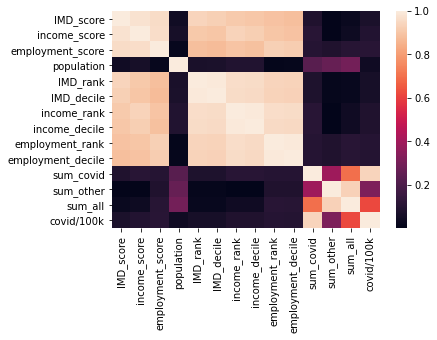

,IMD_score,income_score,employment_score,population,IMD_rank,IMD_decile,income_rank,income_decile,employment_rank,employment_decile,sum_covid,sum_other,sum_all,covid/100k
IMD_score,1.000000,0.976255,0.957567,0.046893,0.938284,0.929397,0.912839,0.904142,0.892932,0.884983,0.083185,0.006963,0.027400,0.072531
income_score,0.976255,1.000000,0.963033,0.062109,0.909281,0.900853,0.933665,0.924950,0.902071,0.894200,0.106867,0.007731,0.036145,0.090175
employment_score,0.957567,0.963033,1.000000,0.016103,0.884079,0.875675,0.897085,0.887945,0.927507,0.918139,0.100094,0.082452,0.103580,0.106293
population,0.046893,0.062109,0.016103,1.000000,0.070057,0.070746,0.087268,0.089241,0.008925,0.012018,0.229441,0.263406,0.295275,0.042749
IMD_rank,0.938284,0.909281,0.884079,0.070057,1.000000,0.994987,0.964762,0.959585,0.939305,0.935025,0.078853,0.014057,0.020177,0.061505
IMD_decile,0.929397,0.900853,0.875675,0.070746,0.994987,1.000000,0.959864,0.955369,0.934652,0.930850,0.079196,0.013475,0.020764,0.061683
income_rank,0.912839,0.933665,0.897085,0.087268,0.964762,0.959864,1.000000,0.994987,0.962138,0.957527,0.108522,0.000065,0.042858,0.085239
income_decile,0.904142,0.924950,0.887945,0.089241,0.959585,0.955369,0.994987,1.000000,0.956721,0.952853,0.106913,0.000332,0.041915,0.083164
employment_rank,0.892932,0.902071,0.927507,0.008925,0.939305,0.934652,0.962138,0.956721,1.000000,0.994987,0.101521,0.084715,0.105903,0.099418
employment_decile,0.884983,0.894200,0.918139,0.012018,0.935025,0.930850,0.957527,0.952853,0.994987,1.000000,0.100527,0.082176,0.103536,0.097671


In [139]:
draw_heatmap(msoa, absolute=True)
msoa.corr().abs()

# So...
based on this, it looks like population density may be the primary factor that influences covid deaths, not how deprived that population is. However, denser populations tend to be more deprived (in most, but not all, metrics).
This is not what you'd expect based on the news and on instinct, so maybe we need to have a think on this.